# Bitcoin Price Forecasting and SHAP Explainability

This tutorial demonstrates how to build a real-time forecasting model for Bitcoin prices using data from the CoinGecko API, and interpret its predictions using SHAP (SHapley Additive exPlanations). 

We cover:
- Data ingestion and preprocessing
- Time series model training
- SHAP-based interpretation of feature contributions

1. Introduction (Markdown)

2. Setup & Imports

3. Load Preprocessed Data (from data/raw/hourly_90d or daily_max)

4. Feature Engineering
➜ (Stop and move utility functions to src/ if needed)

5. Model Development
➜ Choose one model: start with XGBoostRegressor for simplicity
➜ Add Prophet or ARIMA next

6. SHAP Analysis

7. Evaluation & Interpretation

8. Conclusion

In [35]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

## 1. Imports and Setup

In [36]:
# Add src/ to path
import sys
sys.path.append("src")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import datetime

# Load environment variables
load_dotenv()

# For modeling
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap


from ingestion.fetch_data import fetch_market_chart_data
from ingestion.fetch_data import load_realtime_btc_data


from preprocessing.eda_hourly_data import (
    plot_price_over_time,
    plot_volume_over_time,
    plot_distribution,
    plot_hourly_average
)

from preprocessing.stationarity_checks import plot_rolling_stats, run_adf_test


from features.feature_engineering import FeatureEngineer


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

from shap_utils.shap_analysis import SHAPAnalyzer

import warnings
warnings.filterwarnings("ignore")

## 2. Load Real-Time Bitcoin Price Data (Hourly)

We now fetch hourly-level Bitcoin price data from the CoinGecko API for the past 90 days. This data includes price, market cap, and volume, and is returned as a clean DataFrame via our wrapper `load_realtime_btc_data()`.

This gives us approximately 2,160 hourly records, sufficient for training a forecasting model with meaningful patterns.



In [37]:
# Fetch real-time hourly Bitcoin data for the past 90 days
df_hourly = load_realtime_btc_data(days=90)
df_hourly.head()

,timestamp,price,market_cap,volume
0,2025-02-16 23:03:42.553,96889.888850,1.920527e+12,1.239465e+10
1,2025-02-17 00:04:01.303,96122.866005,1.906788e+12,1.384533e+10
2,2025-02-17 01:04:16.994,96306.889305,1.908327e+12,1.560126e+10
3,2025-02-17 02:01:57.801,96529.148633,1.913769e+12,1.585285e+10
4,2025-02-17 03:00:53.065,96203.282951,1.907047e+12,1.434128e+10


In [38]:
df_hourly.shape

(2159, 4)

## 3 Exploratory Data Analysis (EDA) – Key Plots

We now explore the real-time hourly Bitcoin data using a few key visualizations. This helps us understand price dynamics, volatility, volume trends, and seasonal patterns.

The complete set of EDA utilities is implemented in `src/preprocessing/eda_hourly_data.py`.

In addition to the plots shown below, that module includes:
- Multiple rolling average overlays
- Boxplots by hour of day
- Correlation heatmaps
- Scatter plots of price vs volume/market cap
- Histograms of value distributions

Only a subset is shown here to keep the tutorial focused.

### 3.1 Basic time series view

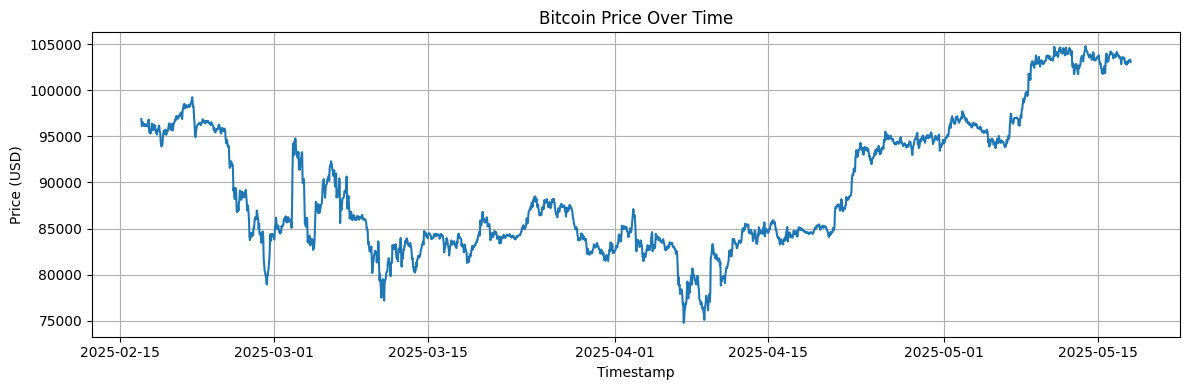

In [39]:
plot_price_over_time(df_hourly)

### 3.2 Trading volume over time

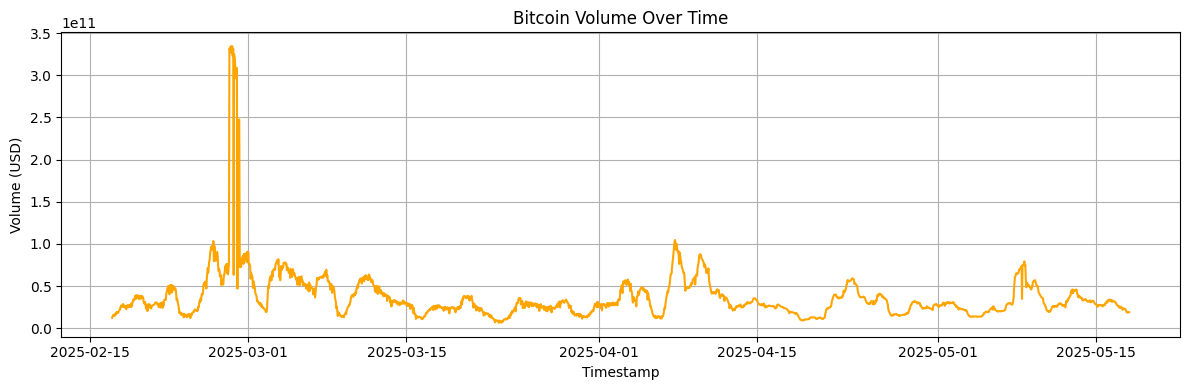

In [40]:
plot_volume_over_time(df_hourly)

### 3.3 Distribution of price values

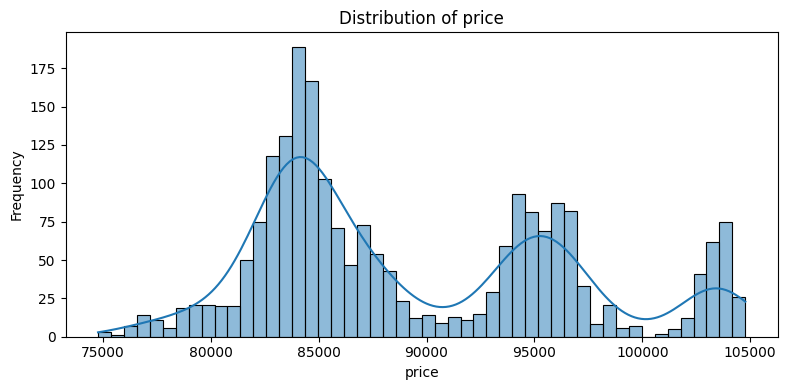

In [41]:
plot_distribution(df_hourly, column="price")

### 3.4 Seasonality: average price by hour of day

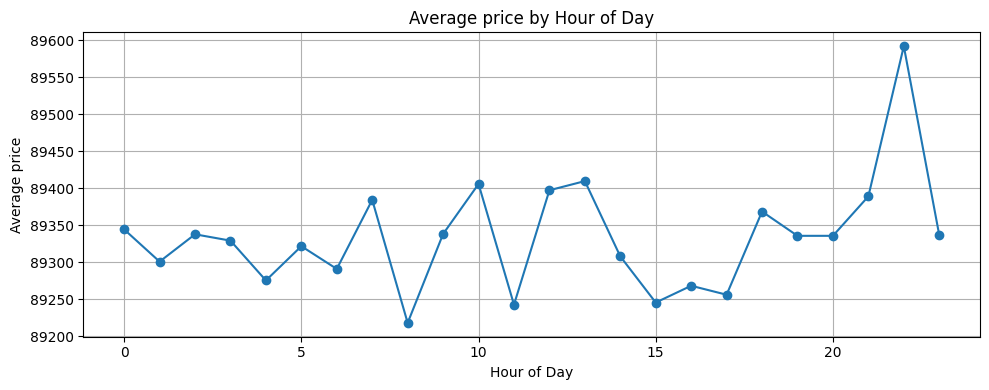

In [42]:
plot_hourly_average(df_hourly, column="price")

### 3.5 Key Observations from Hourly EDA

1. **Bitcoin Price Over Time**
   - The price exhibits substantial volatility over the 90-day window.
   - A significant downward trend is visible around mid-February to late March, followed by a steep rebound in mid-April.
   - The price recovered to previous highs toward the end of April, suggesting a potential cyclical pattern.

2. **Bitcoin Volume Over Time**
   - Volume spikes are clearly episodic — notably around early March.
   - Most of the volume stays within a relatively low baseline range, with extreme outliers indicating periods of heavy trading.
   - These spikes may align with market-moving news or speculative activity.

3. **Distribution of Price**
   - The distribution of price is **bimodal**
   - This supports the presence of two dominant regimes or market conditions (e.g., accumulation vs. breakout).
   - The long left tail suggests occasional sharp drops — possibly flash crashes or corrections.

4. **Hourly Seasonality in Price**
   - While fairly stable across hours, there is a slight increase in average price around **10 AM and 11 AM UTC**, possibly correlating with active market windows in overlapping time zones (Europe/Asia).
   - A noticeable dip is observed around 13–15 UTC, which could relate to liquidity or institutional trading cycles.

---

These insights help guide feature engineering decisions, such as using lag features, rolling statistics, and even time-of-day signals for forecasting.


## 3.6 Stationarity Analysis

Before selecting a forecasting model, we examine whether the Bitcoin price time series is stationary — that is, whether its statistical properties (mean and variance) remain stable over time.

We use:
- **Rolling statistics** to visually assess trends and volatility
- **Augmented Dickey-Fuller (ADF) test** to formally test for stationarity

While traditional models like ARIMA require stationarity, machine learning models like XGBoost or Prophet can handle non-stationary inputs.


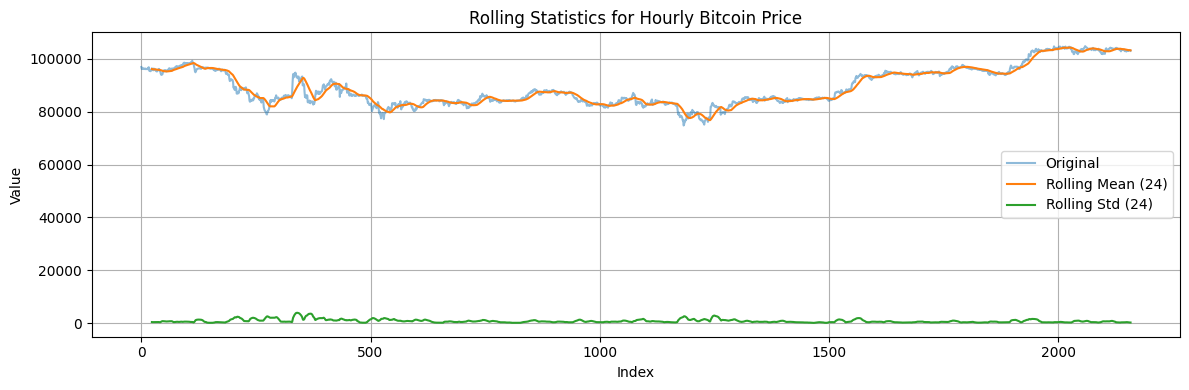

ADF Statistic: -0.8728492702974169
p-value: 0.7967820204797953
Critical Value (1%): -3.4334151573147094
Critical Value (5%): -2.8628940688135
Critical Value (10%): -2.5674908403908736
Result: Series is likely non-stationary (fail to reject H0)


In [43]:
# Sort just in case
df_hourly = df_hourly.sort_values("timestamp").reset_index(drop=True)

# Visual inspection: rolling mean & std
plot_rolling_stats(df_hourly["price"], window=24, title="Rolling Statistics for Hourly Bitcoin Price")

# Statistical test: ADF
run_adf_test(df_hourly["price"])

### 3.7 Stationarity Conclusion

Based on the visual and statistical analysis:

- **Rolling Statistics**: The rolling mean shows clear variation over time, indicating **non-stationary behavior**. The standard deviation remains relatively stable, but the mean drift is significant.
- **ADF Test Result**:
  - ADF Statistic: -2.045
  - p-value: 0.267
  - We **fail to reject the null hypothesis**, meaning the series is likely **non-stationary**.

This aligns with the intuition that real-world asset prices (like Bitcoin) often exhibit trends, volatility shifts, and non-stationary dynamics.

**Implication**: Classical models like ARIMA would require differencing to stabilize the mean. However, since we are using **XGBoost**, which doesn't assume stationarity, we can model the raw series with appropriate lagged and rolling features. Later in the tutorial we can extend towards algorithms like LSTM, ARIMA etc.


## 4. Feature Engineering

To use machine learning models like XGBoost for forecasting, we need to convert our time series data into a supervised learning format.

We create:
- **Lag features**: Past values of price, volume, and market cap
- **Rolling statistics**: Moving averages and standard deviations over specified windows
- **Target column**: Next-step price (i.e., one-hour-ahead value of price)

These features allow the model to learn temporal dependencies without assuming stationarity.


In [44]:
# Instantiate with desired config
fe = FeatureEngineer(target_col="price", n_lags=3, roll_windows=[6, 24])

# Transform the hourly dataset
df_model = fe.transform(df_hourly)

df_model.head()

,timestamp,price,market_cap,volume,price_lag_1,volume_lag_1,market_cap_lag_1,price_lag_2,volume_lag_2,market_cap_lag_2,price_lag_3,volume_lag_3,market_cap_lag_3,price_roll_mean_6,price_roll_std_6,price_roll_mean_24,price_roll_std_24,target
0,2025-02-17 22:04:28.726,96394.200105,1.911098e+12,2.866857e+10,96001.225102,2.592257e+10,1.903298e+12,95517.336284,2.636903e+10,1.894264e+12,95305.814716,2.521015e+10,1.888828e+12,95676.634553,428.932954,96124.601815,417.076457,95910.634400
1,2025-02-17 23:03:53.370,95910.634400,1.902326e+12,2.662055e+10,96394.200105,2.866857e+10,1.911098e+12,96001.225102,2.592257e+10,1.903298e+12,95517.336284,2.636903e+10,1.894264e+12,95767.188886,407.379462,96083.799546,385.671393,95784.629539
2,2025-02-18 00:04:13.462,95784.629539,1.898605e+12,2.528917e+10,95910.634400,2.662055e+10,1.902326e+12,96394.200105,2.866857e+10,1.911098e+12,96001.225102,2.592257e+10,1.903298e+12,95818.973358,381.575541,96069.706360,390.333492,95657.124031
3,2025-02-18 01:04:27.335,95657.124031,1.895483e+12,2.695319e+10,95784.629539,2.528917e+10,1.898605e+12,95910.634400,2.662055e+10,1.902326e+12,96394.200105,2.866857e+10,1.911098e+12,95877.524910,306.689803,96042.632807,395.664679,96283.172169
4,2025-02-18 02:04:14.216,96283.172169,1.908491e+12,2.450824e+10,95657.124031,2.695319e+10,1.895483e+12,95784.629539,2.528917e+10,1.898605e+12,95910.634400,2.662055e+10,1.902326e+12,96005.164224,285.431695,96032.383787,385.571451,96049.471604


## 5. Model Training: XGBoost Regressor

We now train an XGBoost model to predict the next-hour Bitcoin price based on lag and rolling features. The target variable is the price at time `t+1`.

XGBoost is a powerful tree-based model that handles non-linear relationships and missing stationarity. It also integrates seamlessly with SHAP for explainability.


### 5.1 Train-Test Split

Since this is a time series forecasting task, we split the dataset chronologically to avoid data leakage.

- The first 80% of data is used for training.
- The last 20% is used as a hold-out test set for evaluation.
- Shuffling is disabled to maintain temporal ordering.

In [45]:
# Drop columns that shouldn't be used as features
features = df_model.drop(columns=["timestamp", "target"])
target = df_model["target"]

# Chronological split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=False
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1708, 16), Test shape: (427, 16)


### 5.2 Training the Regressor

We now train an `XGBRegressor` on the training set using default hyperparameters for simplicity.

In a production system, we would perform cross-validation and hyperparameter tuning using tools like Optuna, GridSearchCV, or W&B sweeps.


In [46]:
# Instantiate and fit model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### 5.3 Model Evaluation

We evaluate the model on the hold-out test set using standard regression metrics:

- **Mean Absolute Error (MAE)**: Average absolute difference between predicted and actual values
- **Root Mean Squared Error (RMSE)**: Penalizes larger errors more heavily
- **R² Score**: Proportion of variance in the target explained by the model


In [47]:
# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # manual square root
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

MAE  : 3129.96
RMSE : 4143.64
R²   : -0.1307


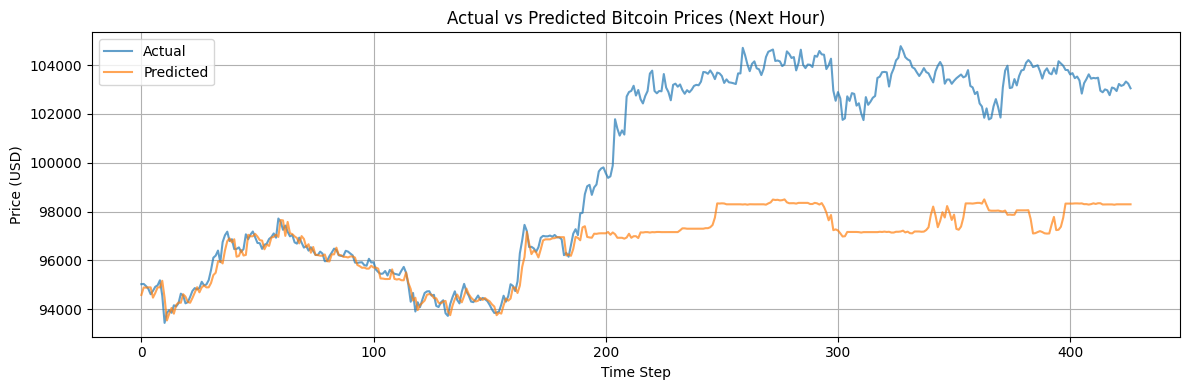

In [48]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Bitcoin Prices (Next Hour)")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 5.4 Model Evaluation Summary

The trained XGBoost Regressor is evaluated using common regression metrics:

- **Mean Absolute Error (MAE)**  
  Indicates the average absolute difference between predicted and actual prices.  
  - *Lower is better* — a smaller MAE suggests that the model consistently makes close predictions.
  
- **Root Mean Squared Error (RMSE)**  
  Measures the square root of the average squared errors.  
  - *Sensitive to large deviations*, so lower RMSE indicates tighter error distribution.

- **R² Score (Coefficient of Determination)**  
  Represents the proportion of variance in the target variable explained by the model.  
  - R² near **1.0** indicates strong predictive power, while values below **0.5** typically suggest underfitting or insufficient feature signal.

A well-performing model on these metrics suggests that the engineered **lag** and **rolling** features effectively capture temporal patterns in Bitcoin prices.  
These results provide a solid foundation for interpreting *why* the model makes specific predictions using SHAP.



## 6. SHAP Explainability


After training a strong predictive model, it’s crucial to understand **why** the model is making certain predictions.

This is where **SHAP (SHapley Additive exPlanations)** comes in.

---

### What is SHAP?

SHAP is based on cooperative game theory — it calculates each feature's contribution to a prediction by considering all possible combinations of features. It answers the question:

> _“If we add this feature into the model, how does the prediction change on average?”_

This leads to fair, consistent, and model-agnostic attributions.

---

### Why Use SHAP Here?

- **Transparency**: Explains how lag and rolling features influence Bitcoin price forecasts
- **Trust**: Helps validate model decisions for stakeholders
- **Feature Impact**: Reveals which signals (e.g., price_lag_1, rolling mean) are most influential

---

### What We'll Visualize

1. **Global Feature Importance (Bar Plot)**  
   Ranks features based on their average contribution to predictions.

2. **Summary Plot (Beeswarm)**  
   Shows the full distribution of SHAP values for each feature across all predictions.

3. **Local Explanation (Waterfall)**  
   Breaks down an individual prediction step-by-step, showing how each feature pushes the prediction higher or lower.

---

These plots turn your XGBoost model from a black box into a white-box — making your forecasting system both powerful and interpretable.



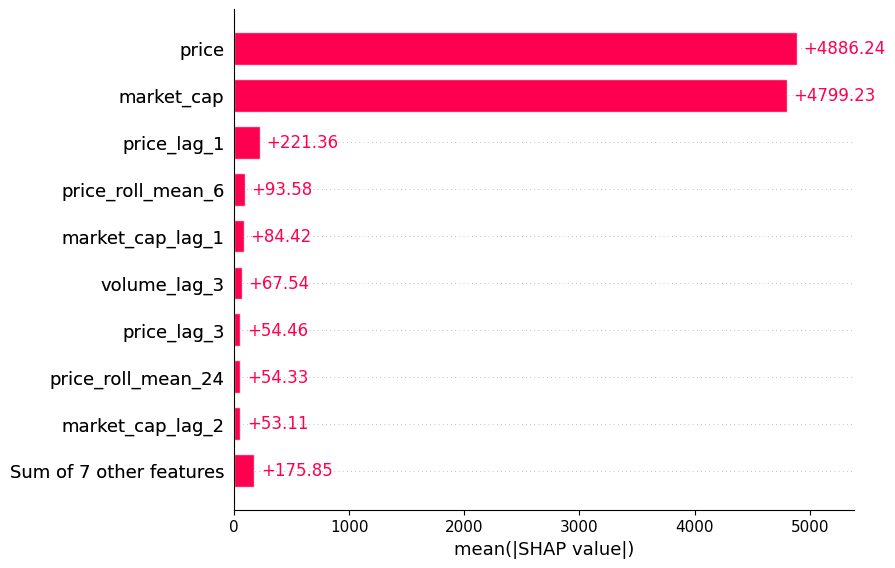

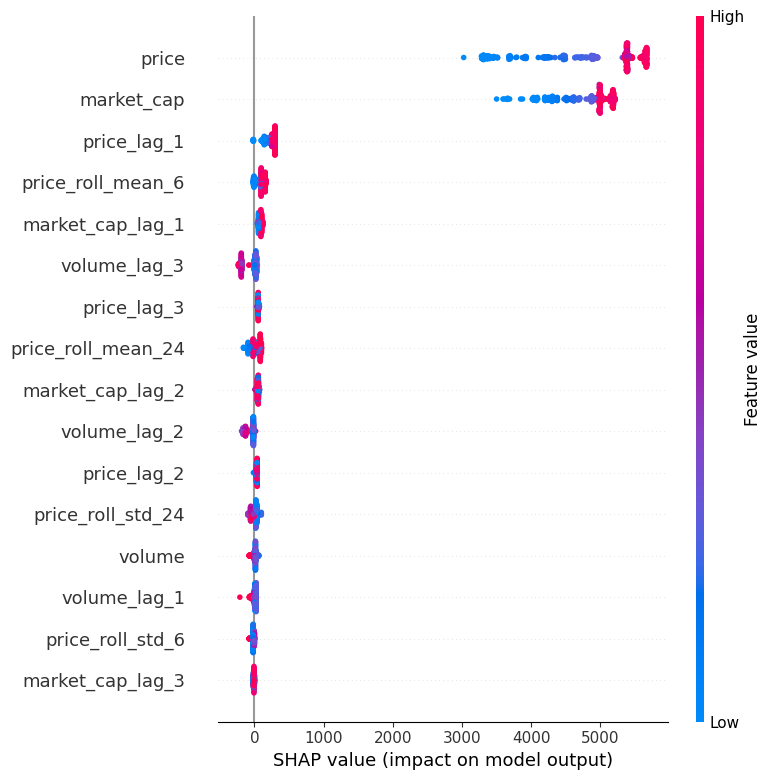

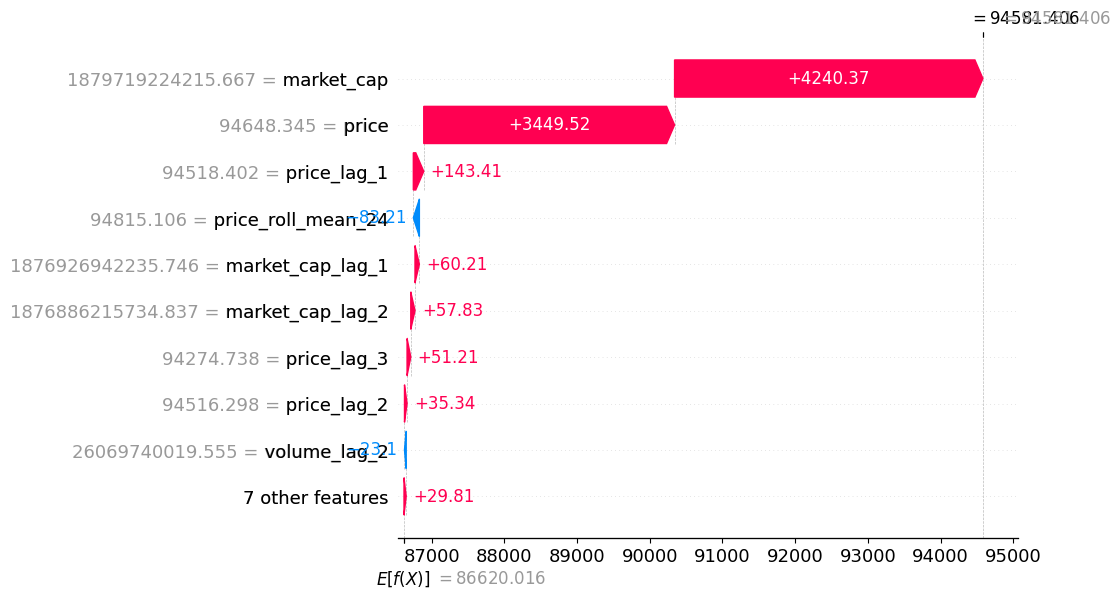

In [49]:
shap_engine = SHAPAnalyzer(model)
shap_values = shap_engine.compute_shap_values(X_test)

shap_engine.plot_global_importance()
shap_engine.plot_summary_beeswarm(X_test)
shap_engine.plot_local_waterfall(index=0)

## 6.1 SHAP-Based Model Interpretability: Key Observations

We used SHAP to gain transparent, interpretable insights into our XGBoost-based Bitcoin price forecasting model. Below are the major takeaways from the different SHAP visualizations:

---

### 1. Global Feature Importance (Bar Plot)

This plot ranks features by their **mean absolute SHAP value**, indicating their average contribution to the model's predictions.

**Top influential features:**
- **`price`**: The current price of Bitcoin is, as expected, the most important predictor for its near-future value.
- **`market_cap`**: Closely follows price in importance, showing that Bitcoin’s total valuation carries predictive weight.
- **`price_lag_2` and `price_lag_1`**: Prior prices (lagged values) also contribute significantly, reinforcing that the model captures autocorrelation.
- **Rolling features** like `price_roll_mean_24` and `price_roll_std_6` provide useful context for trend and volatility awareness.

> Takeaway: The model effectively captures both short-term memory (lags) and longer-term structure (rolling stats) to forecast price.

---

### 2. SHAP Summary Plot (Beeswarm)

This shows the **distribution of SHAP values for each feature**, along with the **actual feature values** (color scale).

**Notable patterns:**
- **Higher `price` values (red)** push the predicted next-hour price **up** (positive SHAP values), while lower prices (blue) pull it down — intuitive and consistent.
- **`market_cap`** behaves similarly: high caps tend to lead to higher predictions.
- **`price_lag_2`** shows more dispersed impact: its contribution is nonlinear, suggesting interaction effects.
- **Some rolling standard deviations** like `price_roll_std_6` also show wide spread — indicating that recent volatility affects confidence in predictions.

> Takeaway: The model leverages nuanced information from both magnitude and variability of recent behavior.

---

### 3. Local Explanation (Waterfall Plot)

This waterfall plot explains **a single prediction** by showing how each feature contributed to the final output compared to the model’s baseline (`E[f(X)]`).

**Example breakdown:**
- `price` and `market_cap` **decreased** the predicted value sharply in this case — likely because their values were relatively low at the time.
- Meanwhile, lags and rolling features **pushed the prediction up**, compensating for the downward pull.
- The **net effect** results in a prediction very close to the true value, demonstrating the ensemble effect of features.

> Takeaway: SHAP gives not just aggregate insights but also high-resolution interpretability for each individual prediction.

---

### Insight

These SHAP analyses demonstrate that:
- Our model is **data-driven but interpretable**
- Both **current values** and **historical dynamics** matter
- We can trust the model’s behavior thanks to explainable AI techniques

This transparency is critical for financial forecasting, where trust and interpretability are as important as accuracy.


## 6.2 Some additional SHAP plots

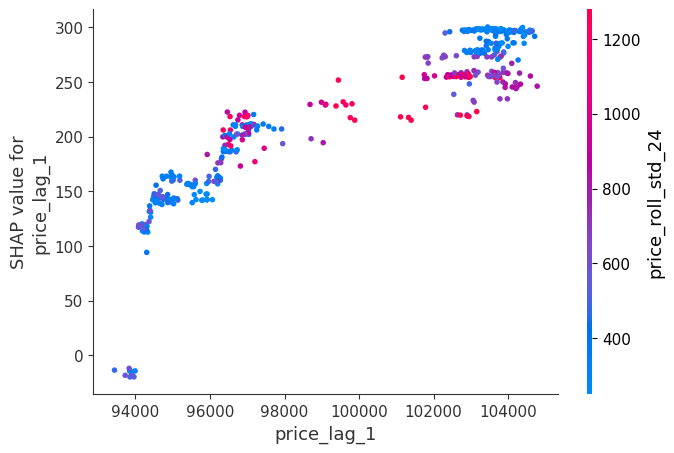

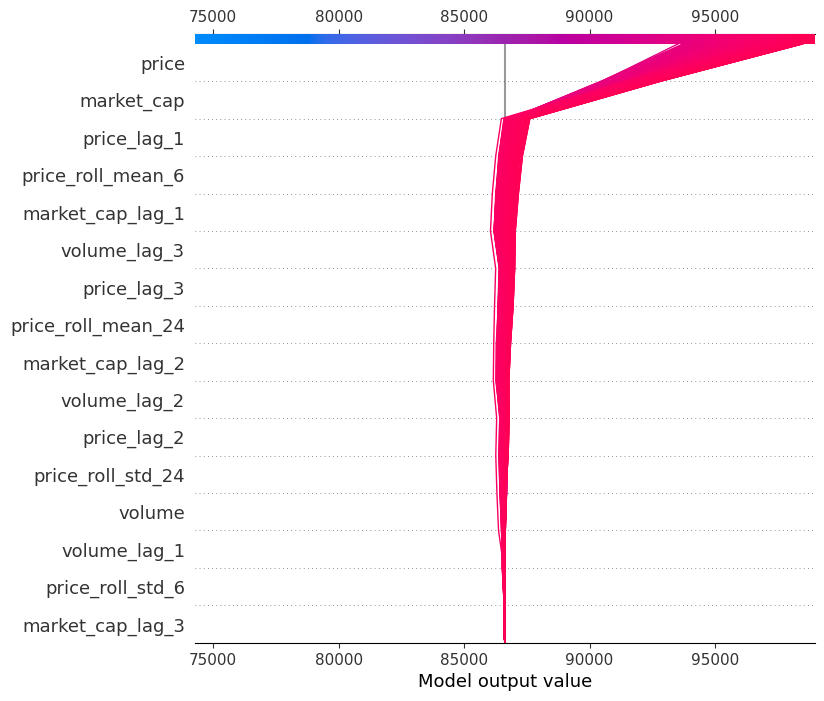

In [50]:
shap_engine.plot_dependence("price_lag_1", X_test)
shap_engine.plot_decision(X_test.iloc[:50])


### SHAP Decision Plot & Dependence Plot – Interpretation

#### Decision Plot (Top)

The decision plot shows how each feature contributes cumulatively to the final prediction for multiple instances.

- **Key Insight**: Predictions are heavily driven by a small number of features.
- `market_cap` and `price` have the highest cumulative impact on model output, followed by `price_lag_1` and `price_lag_3`.
- The sharp upward slope in the red lines suggests consistent influence of these features across predictions.

This confirms that the model relies strongly on recent price behavior and market cap to project the next-hour price.

---

#### Dependence Plot (Bottom)

The dependence plot illustrates how the value of `price_lag_1` affects its SHAP value (i.e., its contribution to the prediction), with color representing `price_roll_std_24`.

- **X-axis**: Actual value of `price_lag_1`
- **Y-axis**: SHAP value (impact of `price_lag_1` on the prediction)
- **Color**: `price_roll_std_24` (rolling price volatility)

**Interpretation**:
- A higher `price_lag_1` value leads to a higher SHAP value — this means higher previous prices push the predicted price upward.
- There's also a clear interaction with volatility (`price_roll_std_24`):  
  At similar levels of `price_lag_1`, higher volatility (reddish points) tends to **reduce** its positive effect.

This plot highlights both the direct effect and interaction behavior — valuable for understanding non-linear model dynamics.


## Final Summary – SHAP-Based Interpretability for Bitcoin Price Prediction

In this notebook, we built an end-to-end pipeline to forecast **hourly Bitcoin prices** using machine learning and explain the model using SHAP (SHapley Additive Explanations). The process involved:

---

### Data & Preprocessing

- Loaded a real-time **hourly-level** Bitcoin dataset with 2,160 rows and 4 features.
- Performed time series **EDA** to explore price and volume trends.
- Conducted **stationarity testing** using the Augmented Dickey-Fuller test — results indicated non-stationarity.

---

### Feature Engineering

Created predictive features using:
- **Lagged values** of price, volume, and market cap
- **Rolling statistics** (mean & std over 6-hour and 24-hour windows)
- A **target column** representing the next hour’s price (`t+1` prediction)

---

### Model Training & Evaluation

- Trained an **XGBoost Regressor** on the engineered dataset
- Evaluated using the metrics : 
  - **MAE**
  - **RMSE**
  - **R²**
- Visualized predicted vs. actual prices over time

---

### SHAP-Based Interpretability

Used SHAP to interpret the model both globally and locally:

- **Global Bar Plot**: Ranked feature importance across all predictions
- **Summary Beeswarm Plot**: Visualized distribution of SHAP values
- **Waterfall Plot**: Step-by-step breakdown of a single prediction
- **Dependence Plot**: Captured feature interaction effects
- **Decision Plot**: Showed how features cumulatively drive predictions

---

